In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch, find_peaks, hilbert
from scipy.fftpack import fft2
import pywt
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [4]:
# Load the milling machine dataset
df = pd.read_csv(r'F:\milling_machine_conditions_with_tool_wear_seconds.csv')


print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
display(df.head())
print("\nDataset info:")
df.info()
print("\nFailure Types distribution:")
print(df['Failure Types'].value_counts())
print("\nTarget distribution:")
print(df['Target'].value_counts())

Dataset shape: (10000, 7)

Column names:
['Air Temp (°C)', 'Process Temp (°C)', 'Rotational Speed (RPM)', 'Torque (Nm)', 'Tool Wear (Seconds)', 'Target', 'Failure Types']

First few rows:


,Air Temp (°C),Process Temp (°C),Rotational Speed (RPM),Torque (Nm),Tool Wear (Seconds),Target,Failure Types
0,29.021640,71.620737,1515.840689,50.223021,664.638000,0,No Failure
1,21.886075,69.896471,2083.417786,52.221351,6628.080758,0,No Failure
2,29.020744,74.731134,2455.801496,57.822145,3295.576818,0,No Failure
3,25.793868,70.715109,2112.654324,69.910072,7116.479752,0,No Failure
4,21.056760,71.025092,1642.485295,68.411333,1191.996403,0,No Failure



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Air Temp (°C)           10000 non-null  float64
 1   Process Temp (°C)       10000 non-null  float64
 2   Rotational Speed (RPM)  10000 non-null  float64
 3   Torque (Nm)             10000 non-null  float64
 4   Tool Wear (Seconds)     10000 non-null  float64
 5   Target                  10000 non-null  int64  
 6   Failure Types           10000 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 547.0+ KB

Failure Types distribution:
Failure Types
No Failure                  2000
Power Failure               2000
Heat Dissipation Failure    2000
Overstrain                  2000
Tool Wear Failure           2000
Name: count, dtype: int64

Target distribution:
Target
1    8000
0    2000
Name: count, dtype: int64


In [5]:
"""
Since this dataset contains tabular sensor readings (not raw time series signals),
we'll create synthetic time series by simulating signal behavior based on the sensor values.
This approach generates realistic signal patterns for each sample.
"""

def create_synthetic_signal(row, signal_length=10000, fs=1e6):
    """
    Create a synthetic vibration signal based on sensor parameters.
    The signal combines multiple components typical of machinery vibration.
    """
    t = np.linspace(0, signal_length/fs, signal_length)
    
    # Base frequency from rotational speed (convert RPM to Hz)
    base_freq = row['Rotational Speed (RPM)'] / 60
    
    # Multiple harmonics typical of machine vibration
    signal = np.zeros(signal_length)
    
    # Fundamental frequency component (proportional to speed)
    signal += row['Torque (Nm)'] * np.sin(2 * np.pi * base_freq * t)
    
    # 2nd harmonic (gear meshing)
    signal += 0.6 * row['Torque (Nm)'] * np.sin(2 * np.pi * 2 * base_freq * t + np.pi/4)
    
    # 3rd harmonic
    signal += 0.3 * row['Torque (Nm)'] * np.sin(2 * np.pi * 3 * base_freq * t + np.pi/3)
    
    # High-frequency component from bearing (modulated by wear)
    bearing_freq = base_freq * 10 * (1 + row['Tool Wear (Seconds)'] / 1e6)
    signal += 0.4 * np.sin(2 * np.pi * bearing_freq * t)
    
    # Temperature-dependent noise (thermal expansion effects)
    temp_factor = (row['Air Temp (°C)'] + row['Process Temp (°C)']) / 50
    signal += temp_factor * np.random.normal(0, 0.5, signal_length)
    
    # Tool wear creates amplitude modulation
    wear_modulation = 1 + 0.3 * row['Tool Wear (Seconds)'] / 1e7 * np.sin(2 * np.pi * base_freq/10 * t)
    signal *= wear_modulation
    
    # Add random bursts for failure conditions
    if row['Target'] == 1:  # Failure condition
        num_bursts = np.random.randint(3, 8)
        for _ in range(num_bursts):
            burst_pos = np.random.randint(0, signal_length - 500)
            burst_duration = np.random.randint(100, 500)
            burst_amp = np.random.uniform(5, 15)
            signal[burst_pos:burst_pos+burst_duration] += burst_amp * np.random.randn(burst_duration)
    
    return signal

# Group by Failure Types
failure_types = df['Failure Types'].unique()
print(f"Found {len(failure_types)} failure types:")
for ft in failure_types:
    count = len(df[df['Failure Types'] == ft])
    print(f"  {ft}: {count} samples")

Found 5 failure types:
  No Failure: 2000 samples
  Power Failure: 2000 samples
  Heat Dissipation Failure: 2000 samples
  Overstrain: 2000 samples
  Tool Wear Failure: 2000 samples


In [6]:
# Parameters
FRAME_SIZE = 10000
NUM_SAMPLES_PER_CLASS = 200  # Take up to 200 samples per class for balance

# Create signals for each failure type
raw_signals = {}
segmented_data = {}

for failure_type in failure_types:
    print(f"\nProcessing: {failure_type}")
    
    # Get samples for this failure type
    class_data = df[df['Failure Types'] == failure_type]
    
    # Limit samples for computational efficiency
    if len(class_data) > NUM_SAMPLES_PER_CLASS:
        class_data = class_data.sample(n=NUM_SAMPLES_PER_CLASS, random_state=42)
    
    signals = []
    for idx, row in class_data.iterrows():
        signal = create_synthetic_signal(row, signal_length=FRAME_SIZE)
        signals.append(signal)
    
    raw_signals[failure_type] = signals
    segmented_data[failure_type] = signals  # Already segmented to FRAME_SIZE
    
    print(f"  {failure_type}: Generated {len(signals)} signals, each with {FRAME_SIZE} samples")

print("\n✅ Signal generation complete")


Processing: No Failure
  No Failure: Generated 200 signals, each with 10000 samples

Processing: Power Failure
  Power Failure: Generated 200 signals, each with 10000 samples

Processing: Heat Dissipation Failure
  Heat Dissipation Failure: Generated 200 signals, each with 10000 samples

Processing: Overstrain
  Overstrain: Generated 200 signals, each with 10000 samples

Processing: Tool Wear Failure
  Tool Wear Failure: Generated 200 signals, each with 10000 samples

✅ Signal generation complete


In [7]:
def denoise_wavelet(frame, wavelet='db4', level=3):
    """Apply wavelet denoising to a single 1D signal frame."""
    coeffs = pywt.wavedec(frame, wavelet=wavelet, level=level)
    
    # Universal threshold
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(frame)))
    
    # Apply soft thresholding to detail coefficients
    coeffs_thresh = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    
    # Reconstruct signal
    denoised = pywt.waverec(coeffs_thresh, wavelet=wavelet)
    return denoised[:len(frame)]

denoised_data = {}

for failure_type, frames in segmented_data.items():
    denoised_frames = [denoise_wavelet(frame) for frame in frames]
    denoised_data[failure_type] = denoised_frames
    print(f"{failure_type}: Denoised {len(denoised_frames)} frames")

print("\n✅ Wavelet denoising complete")

No Failure: Denoised 200 frames
Power Failure: Denoised 200 frames
Heat Dissipation Failure: Denoised 200 frames
Overstrain: Denoised 200 frames
Tool Wear Failure: Denoised 200 frames

✅ Wavelet denoising complete


In [8]:
def denoise_wavelet(frame, wavelet='db4', level=3):
    """Apply wavelet denoising to a single 1D signal frame."""
    coeffs = pywt.wavedec(frame, wavelet=wavelet, level=level)
    
    # Universal threshold
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(frame)))
    
    # Apply soft thresholding to detail coefficients
    coeffs_thresh = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    
    # Reconstruct signal
    denoised = pywt.waverec(coeffs_thresh, wavelet=wavelet)
    return denoised[:len(frame)]

denoised_data = {}

for failure_type, frames in segmented_data.items():
    denoised_frames = [denoise_wavelet(frame) for frame in frames]
    denoised_data[failure_type] = denoised_frames
    print(f"{failure_type}: Denoised {len(denoised_frames)} frames")

print("\n✅ Wavelet denoising complete")

No Failure: Denoised 200 frames
Power Failure: Denoised 200 frames
Heat Dissipation Failure: Denoised 200 frames
Overstrain: Denoised 200 frames
Tool Wear Failure: Denoised 200 frames

✅ Wavelet denoising complete


In [9]:
def compute_energy(frame):
    """Compute signal energy (sum of squares)."""
    return np.sum(frame ** 2)

def select_burst_frames(frames, top_ratio=0.7):
    """Select top `top_ratio` burst frames based on energy."""
    energies = np.array([compute_energy(f) for f in frames])
    threshold = np.percentile(energies, 100 * (1 - top_ratio))
    selected = [f for f, e in zip(frames, energies) if e >= threshold]
    return selected, energies, threshold

burst_selected_data = {}
burst_stats = {}

for failure_type, frames in denoised_data.items():
    selected, energies, threshold = select_burst_frames(frames, top_ratio=0.7)
    burst_selected_data[failure_type] = selected
    burst_stats[failure_type] = {
        'total_frames': len(frames),
        'selected_frames': len(selected),
        'energy_threshold': threshold
    }
    print(f"{failure_type}: Selected {len(selected)} burst frames (threshold = {threshold:.2e})")

print("\n✅ Burst frame selection complete")

No Failure: Selected 140 burst frames (threshold = 2.41e+07)
Power Failure: Selected 140 burst frames (threshold = 3.51e+05)
Heat Dissipation Failure: Selected 140 burst frames (threshold = 2.57e+07)
Overstrain: Selected 140 burst frames (threshold = 3.40e+07)
Tool Wear Failure: Selected 140 burst frames (threshold = 2.30e+06)

✅ Burst frame selection complete


In [10]:
def extract_td_fd_features(frame, fs=1e6):
    features = []

    # Time-Domain Features
    mean_val = np.mean(frame)
    std_val = np.std(frame)
    var_val = np.var(frame)
    rms_val = np.sqrt(np.mean(frame**2))
    peak_val = np.max(np.abs(frame))
    ptp_val = np.ptp(frame)
    crest_factor = peak_val / rms_val if rms_val != 0 else 0
    impulse_factor = peak_val / np.mean(np.abs(frame)) if np.mean(np.abs(frame)) != 0 else 0
    shape_factor = rms_val / np.mean(np.abs(frame)) if np.mean(np.abs(frame)) != 0 else 0
    margin_factor = peak_val / (np.mean(np.sqrt(np.abs(frame)))**2) if np.mean(np.sqrt(np.abs(frame))) != 0 else 0
    skewness = skew(frame)
    kurt = kurtosis(frame)
    energy = np.sum(frame**2)
    zcr = ((frame[:-1] * frame[1:]) < 0).sum()
    mav = np.mean(np.abs(frame))
    max_val = np.max(frame)
    min_val = np.min(frame)
    range_val = max_val - min_val
    duration = len(frame) / fs
    envelope_area = np.trapz(np.abs(frame))

    # Frequency-Domain Features (Welch)
    freqs, psd = welch(frame, fs=fs, nperseg=min(1024, len(frame)))
    psd = np.nan_to_num(psd)

    spectral_energy = np.sum(psd)
    spectral_centroid = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) != 0 else 0
    spectral_entropy = entropy(psd + 1e-12)
    spectral_kurtosis = kurtosis(psd)
    spectral_skewness = skew(psd)
    spectral_flatness = np.exp(np.mean(np.log(psd + 1e-12))) / np.mean(psd) if np.mean(psd) != 0 else 0
    dominant_freq = freqs[np.argmax(psd)]
    median_freq_idx = np.where(np.cumsum(psd) >= np.sum(psd)/2)[0]
    median_freq = freqs[median_freq_idx[0]] if len(median_freq_idx) > 0 else 0
    mean_freq = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) != 0 else 0
    freq_variance = np.var(psd)
    freq_rms = np.sqrt(np.mean(psd**2))
    freq_spread = np.std(freqs)

    # THD
    harmonics, _ = find_peaks(psd, height=np.max(psd)*0.1)
    thd = np.sum(psd[harmonics[1:]]) / psd[harmonics[0]] if len(harmonics) > 1 and psd[harmonics[0]] > 0 else 0

    features.extend([
        mean_val, rms_val, std_val, var_val,
        skewness, kurt, peak_val, ptp_val,
        crest_factor, impulse_factor, shape_factor, margin_factor,
        energy, max_val, min_val, range_val,
        zcr, duration, mav, envelope_area,
        mean_freq, median_freq, dominant_freq, spectral_centroid,
        spectral_entropy, spectral_kurtosis, spectral_skewness,
        spectral_flatness, spectral_energy, freq_variance,
        freq_rms, freq_spread, thd
    ])

    return features

td_fd_features = []
td_fd_labels = []

for failure_type, frames in burst_selected_data.items():
    for frame in frames:
        features = extract_td_fd_features(frame)
        td_fd_features.append(features)
        td_fd_labels.append(failure_type)

feature_names = [
    "Mean", "RMS", "STD", "Variance", "Skewness", "Kurtosis",
    "Peak", "PeakToPeak", "CrestFactor", "ImpulseFactor", "ShapeFactor", "MarginFactor",
    "SignalEnergy", "MaxVal", "MinVal", "Range", "ZCR", "Duration", "MAV", "EnvelopeArea",
    "MeanFreq", "MedianFreq", "DominantFreq", "SpectralCentroid", "SpectralEntropy",
    "SpectralKurtosis", "SpectralSkewness", "SpectralFlatness", "SpectralEnergy",
    "FreqVariance", "FreqRMS", "FreqSpread", "THD"
]

td_fd_df = pd.DataFrame(td_fd_features, columns=feature_names)
td_fd_df['Label'] = td_fd_labels

print("✅ TD + FD feature extraction complete.")
print("DataFrame shape:", td_fd_df.shape)
display(td_fd_df.head())

✅ TD + FD feature extraction complete.
DataFrame shape: (700, 34)


,Mean,RMS,STD,Variance,Skewness,Kurtosis,Peak,PeakToPeak,CrestFactor,ImpulseFactor,...,SpectralEntropy,SpectralKurtosis,SpectralSkewness,SpectralFlatness,SpectralEnergy,FreqVariance,FreqRMS,FreqSpread,THD,Label
0,50.687324,53.680037,17.673189,312.341622,-0.134984,-1.514057,74.649996,50.403436,1.390647,1.472755,...,0.680393,505.490234,22.502046,0.000062,0.002107,6.887988e-09,0.000083,144619.201843,0.0,No Failure
1,46.431249,49.748777,17.862809,319.079936,0.574091,-1.270171,78.155651,52.615129,1.571006,1.683255,...,0.576936,504.631076,22.474474,0.000037,0.003374,1.794055e-08,0.000134,144619.201843,0.0,No Failure
2,51.862367,55.534953,19.860159,394.425928,0.458413,-1.390117,85.420356,57.015028,1.538137,1.647059,...,0.501222,505.056939,22.488092,0.000029,0.003722,2.241483e-08,0.000150,144619.201843,0.0,No Failure
3,48.787125,51.534321,16.601286,275.602681,-0.177187,-1.482188,70.917370,47.695296,1.376119,1.453608,...,0.686524,505.019119,22.487141,0.000065,0.001906,5.601227e-09,0.000075,144619.201843,0.0,No Failure
4,56.736733,60.434474,20.815110,433.268784,-0.019371,-1.573840,86.294852,58.081090,1.427908,1.520970,...,0.605441,505.357424,22.497828,0.000047,0.002947,1.375008e-08,0.000117,144619.201843,0.0,No Failure


In [11]:
def extract_tfd_features_cwt(frame, wavelet='cmor1.5-1.0', fs=1e6, num_scales=64):
    """Extract time-frequency domain features using CWT."""
    scales = np.arange(1, num_scales + 1)
    coef, _ = pywt.cwt(frame, scales=scales, wavelet=wavelet, sampling_period=1/fs)

    scalogram = np.abs(coef)
    tfd_energy = np.sum(scalogram**2)
    tfd_entropy = entropy(scalogram.flatten() + 1e-12)
    tfd_mean = np.mean(scalogram)
    tfd_std = np.std(scalogram)
    tfd_max = np.max(scalogram)
    tfd_kurt = kurtosis(scalogram.flatten())
    tfd_skew = skew(scalogram.flatten())
    tfd_centroid = np.sum(scalogram * np.arange(scalogram.shape[0])[:, None]) / (np.sum(scalogram) + 1e-12)

    # Ridge Energy Ratio
    flat = scalogram.flatten()
    top_k = np.percentile(flat, 95)
    ridge_energy = np.sum(flat[flat >= top_k]) / (np.sum(flat) + 1e-12)

    return [
        tfd_energy, tfd_entropy, tfd_mean, tfd_std,
        tfd_max, tfd_kurt, tfd_skew, tfd_centroid,
        ridge_energy
    ]

tfd_features = []
tfd_labels = []

for failure_type, frames in burst_selected_data.items():
    for frame in frames:
        tfd_feat = extract_tfd_features_cwt(frame)
        tfd_features.append(tfd_feat)
        tfd_labels.append(failure_type)

tfd_feature_names = [
    "TFD_Energy", "TFD_Entropy", "TFD_Mean", "TFD_STD", "TFD_Max",
    "TFD_Kurtosis", "TFD_Skewness", "TFD_Centroid", "TFD_RidgeEnergyRatio"
]

tfd_df = pd.DataFrame(tfd_features, columns=tfd_feature_names)
tfd_df['Label'] = tfd_labels

print("✅ CWT-based TFD feature extraction complete.")
print("TFD DataFrame shape:", tfd_df.shape)
display(tfd_df.head())

✅ CWT-based TFD feature extraction complete.
TFD DataFrame shape: (700, 10)


,TFD_Energy,TFD_Entropy,TFD_Mean,TFD_STD,TFD_Max,TFD_Kurtosis,TFD_Skewness,TFD_Centroid,TFD_RidgeEnergyRatio,Label
0,1.057117e+06,12.606201,0.479053,1.192583,24.775875,173.990317,12.215278,39.490690,0.311713,No Failure
1,1.250460e+06,12.508652,0.476618,1.314032,26.091238,163.076153,11.970782,39.672249,0.340870,No Failure
2,1.566019e+06,12.358845,0.466200,1.493172,29.046391,160.599959,12.008243,40.067637,0.383183,No Failure
3,9.824665e+05,12.588004,0.460614,1.150191,23.822625,170.558033,12.058519,39.836680,0.319509,No Failure
4,1.385785e+06,12.536196,0.513014,1.379168,28.659820,171.512600,12.195974,39.794302,0.331525,No Failure


In [12]:
def extract_hos_features(frame):
    features = []

    # Central Moments
    centered = frame - np.mean(frame)
    m3 = np.mean(centered**3)
    m4 = np.mean(centered**4)
    m5 = np.mean(centered**5)

    # Cumulants
    c3 = m3
    c4 = m4 - 3 * (np.var(frame)**2)

    # Gaussianity index
    g_index = c4 / m4 if m4 != 0 else 0

    # Bispectrum (simplified)
    analytic_signal = hilbert(frame)
    N = min(len(frame) // 2, 1000)  # Limit for computational efficiency
    X = fft2(np.outer(analytic_signal[:N], analytic_signal[:N]))
    bispec = np.abs(X)
    bicoherence = bispec / (np.outer(np.abs(analytic_signal[:N])**2, np.abs(analytic_signal[:N])**2) + 1e-12)

    bispec_mean = np.mean(bispec)
    bicoherence_mean = np.mean(bicoherence)

    # Nonlinearity index
    nonlinearity_index = c3**2 + c4**2

    features.extend([
        m3, m4, m5,
        c3, c4,
        g_index,
        bispec_mean,
        bicoherence_mean,
        nonlinearity_index
    ])

    return features

hos_features = []
hos_labels = []

for failure_type, frames in burst_selected_data.items():
    for frame in frames:
        hos_feat = extract_hos_features(frame)
        hos_features.append(hos_feat)
        hos_labels.append(failure_type)

hos_feature_names = [
    "Moment3", "Moment4", "Moment5",
    "Cumulant3", "Cumulant4",
    "GaussianityIndex",
    "BispectrumMean", "BicoherenceMean",
    "NonlinearityIndex"
]

hos_df = pd.DataFrame(hos_features, columns=hos_feature_names)
hos_df['Label'] = hos_labels

print("✅ HOS feature extraction complete.")
print("HOS DataFrame shape:", hos_df.shape)
display(hos_df.head())

✅ HOS feature extraction complete.
HOS DataFrame shape: (700, 10)


,Moment3,Moment4,Moment5,Cumulant3,Cumulant4,GaussianityIndex,BispectrumMean,BicoherenceMean,NonlinearityIndex,Label
0,-745.123480,144964.588919,-7.197561e+05,-745.123480,-147707.277777,-1.018920,17363.226409,0.000883,2.181800e+10,No Failure
1,3272.127792,176117.386211,3.454215e+06,3272.127792,-129318.630610,-0.734275,21436.103093,0.001118,1.673402e+10,No Failure
2,3590.915690,250452.352334,4.533215e+06,3590.915690,-216263.086848,-0.863490,21890.949412,0.000956,4.678262e+10,No Failure
3,-810.693088,115288.201574,-7.230947e+05,-810.693088,-112582.312278,-0.976529,15418.519309,0.000948,1.267543e+10,No Failure
4,-174.696649,267721.314214,-8.988396e+04,-174.696649,-295444.203166,-1.103551,22934.962828,0.000677,8.728731e+10,No Failure


In [13]:
def extract_burst_features(frame, fs=1e6, threshold_ratio=0.25):
    features = []

    threshold = threshold_ratio * np.max(np.abs(frame))
    indices = np.where(np.abs(frame) > threshold)[0]

    if len(indices) == 0:
        return [0]*10

    # Group consecutive indices as bursts
    burst_starts = [indices[0]]
    burst_durations = []
    current_duration = 1

    for i in range(1, len(indices)):
        if indices[i] == indices[i-1] + 1:
            current_duration += 1
        else:
            burst_durations.append(current_duration / fs)
            burst_starts.append(indices[i])
            current_duration = 1
    burst_durations.append(current_duration / fs)

    num_bursts = len(burst_durations)
    burst_energies = []
    burst_peaks = []
    rms_bursts = []
    
    for s, d in zip(burst_starts, burst_durations):
        end_idx = min(s + int(d*fs), len(frame))
        segment = frame[s:end_idx]
        if len(segment) > 0:
            burst_energies.append(np.sum(segment**2))
            burst_peaks.append(np.max(np.abs(segment)))
            rms_bursts.append(np.sqrt(np.mean(segment**2)))
    
    inter_burst_intervals = np.diff(burst_starts) / fs if len(burst_starts) > 1 else np.array([])

    total_event_duration = np.sum(burst_durations)
    cumulative_counts = np.sum([int(d*fs) for d in burst_durations])

    features.extend([
        num_bursts,
        np.mean(burst_durations) if len(burst_durations) > 0 else 0,
        np.mean(inter_burst_intervals) if len(inter_burst_intervals) > 0 else 0,
        np.mean(burst_energies) if len(burst_energies) > 0 else 0,
        np.mean(burst_peaks) if len(burst_peaks) > 0 else 0,
        np.mean(rms_bursts) if len(rms_bursts) > 0 else 0,
        cumulative_counts,
        total_event_duration,
        np.max(burst_peaks) if len(burst_peaks) > 0 else 0,
        np.min(burst_peaks) if len(burst_peaks) > 0 else 0
    ])

    return features

burst_features = []
burst_labels = []

for failure_type, frames in burst_selected_data.items():
    for frame in frames:
        burst_feat = extract_burst_features(frame)
        burst_features.append(burst_feat)
        burst_labels.append(failure_type)

burst_feature_names = [
    "NumBursts", "AvgBurstDuration", "AvgInterBurstInterval",
    "AvgBurstEnergy", "AvgBurstPeak", "AvgBurstRMS",
    "CumulativeCounts", "TotalEventDuration",
    "MaxBurstPeak", "MinBurstPeak"
]

burst_df = pd.DataFrame(burst_features, columns=burst_feature_names)
burst_df['Label'] = burst_labels

print("✅ AE Burst feature extraction complete.")
print("Burst Feature DataFrame shape:", burst_df.shape)
display(burst_df.head())

✅ AE Burst feature extraction complete.
Burst Feature DataFrame shape: (700, 11)


,NumBursts,AvgBurstDuration,AvgInterBurstInterval,AvgBurstEnergy,AvgBurstPeak,AvgBurstRMS,CumulativeCounts,TotalEventDuration,MaxBurstPeak,MinBurstPeak,Label
0,1,0.01,0.0,2.881546e+07,74.649996,53.680037,10000,0.01,74.649996,74.649996,No Failure
1,1,0.01,0.0,2.474941e+07,78.155651,49.748777,10000,0.01,78.155651,78.155651,No Failure
2,1,0.01,0.0,3.084131e+07,85.420356,55.534953,10000,0.01,85.420356,85.420356,No Failure
3,1,0.01,0.0,2.655786e+07,70.917370,51.534321,10000,0.01,70.917370,70.917370,No Failure
4,1,0.01,0.0,3.652326e+07,86.294852,60.434474,10000,0.01,86.294852,86.294852,No Failure


In [14]:
# Drop duplicate Label columns
td_fd_df_clean = td_fd_df.drop(columns=['Label'])
tfd_df_clean = tfd_df.drop(columns=['Label'])
hos_df_clean = hos_df.drop(columns=['Label'])
burst_df_clean = burst_df.drop(columns=['Label'])

# Concatenate all features
combined_features = pd.concat([td_fd_df_clean, tfd_df_clean, hos_df_clean, burst_df_clean], axis=1)
combined_features['Label'] = burst_labels

print("✅ All features combined.")
print("Final feature shape:", combined_features.shape)
display(combined_features.head())
display(combined_features['Label'].value_counts())

✅ All features combined.
Final feature shape: (700, 62)


,Mean,RMS,STD,Variance,Skewness,Kurtosis,Peak,PeakToPeak,CrestFactor,ImpulseFactor,...,AvgBurstDuration,AvgInterBurstInterval,AvgBurstEnergy,AvgBurstPeak,AvgBurstRMS,CumulativeCounts,TotalEventDuration,MaxBurstPeak,MinBurstPeak,Label
0,50.687324,53.680037,17.673189,312.341622,-0.134984,-1.514057,74.649996,50.403436,1.390647,1.472755,...,0.01,0.0,2.881546e+07,74.649996,53.680037,10000,0.01,74.649996,74.649996,No Failure
1,46.431249,49.748777,17.862809,319.079936,0.574091,-1.270171,78.155651,52.615129,1.571006,1.683255,...,0.01,0.0,2.474941e+07,78.155651,49.748777,10000,0.01,78.155651,78.155651,No Failure
2,51.862367,55.534953,19.860159,394.425928,0.458413,-1.390117,85.420356,57.015028,1.538137,1.647059,...,0.01,0.0,3.084131e+07,85.420356,55.534953,10000,0.01,85.420356,85.420356,No Failure
3,48.787125,51.534321,16.601286,275.602681,-0.177187,-1.482188,70.917370,47.695296,1.376119,1.453608,...,0.01,0.0,2.655786e+07,70.917370,51.534321,10000,0.01,70.917370,70.917370,No Failure
4,56.736733,60.434474,20.815110,433.268784,-0.019371,-1.573840,86.294852,58.081090,1.427908,1.520970,...,0.01,0.0,3.652326e+07,86.294852,60.434474,10000,0.01,86.294852,86.294852,No Failure


Label
No Failure                  140
Power Failure               140
Heat Dissipation Failure    140
Overstrain                  140
Tool Wear Failure           140
Name: count, dtype: int64

In [15]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Separate features and labels
X = combined_features.drop(columns=['Label']).values
y = combined_features['Label'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("✅ Features normalized and labels encoded.")
print("X_scaled shape:", X_scaled.shape)
print("y_encoded shape:", y_encoded.shape)
print("\nClass mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {class_name} → {i} ({count} samples)")

✅ Features normalized and labels encoded.
X_scaled shape: (700, 61)
y_encoded shape: (700,)

Class mapping:
  Heat Dissipation Failure → 0 (140 samples)
  No Failure → 1 (140 samples)
  Overstrain → 2 (140 samples)
  Power Failure → 3 (140 samples)
  Tool Wear Failure → 4 (140 samples)


In [16]:
# Reconstruct feature DataFrame
final_feature_names = combined_features.drop(columns=['Label']).columns.tolist()
df_export = pd.DataFrame(X_scaled, columns=final_feature_names)
df_export['Label'] = y
df_export['EncodedLabel'] = y_encoded

# Export to Excel
excel_path = 'milling_machine_features.xlsx'
df_export.to_excel(excel_path, index=False)

print(f"✅ Feature set saved to Excel at: {excel_path}")

✅ Feature set saved to Excel at: milling_machine_features.xlsx


In [17]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

print("✅ Data split complete")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print("\nClass distribution in training set:")
for i, class_name in enumerate(label_encoder.classes_):
    count = np.sum(y_train == i)
    print(f"  {class_name}: {count} samples")

✅ Data split complete
Training samples: 490
Testing samples: 210

Class distribution in training set:
  Heat Dissipation Failure: 98 samples
  No Failure: 98 samples
  Overstrain: 98 samples
  Power Failure: 98 samples
  Tool Wear Failure: 98 samples


In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Install pytorch-tabnet if not already installed
# !pip install pytorch-tabnet

from pytorch_tabnet.tab_model import TabNetClassifier

# K-Fold setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Storage for results
fold_results = {
    'TabNet': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'SVM': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'RF': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'Ensemble': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
}

print("✅ K-Fold Cross Validation Setup Complete")
print(f"Number of folds: {n_splits}")

✅ K-Fold Cross Validation Setup Complete
Number of folds: 5


In [19]:
fold = 1

for train_idx, val_idx in skf.split(X_train, y_train):
    print(f"\n{'='*60}")
    print(f"Fold {fold}/{n_splits}")
    print(f"{'='*60}")
    
    # Split data
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
    
    # Convert to float32 for TabNet
    X_fold_train_tab = X_fold_train.astype(np.float32)
    X_fold_val_tab = X_fold_val.astype(np.float32)
    
    # Train TabNet
    print("\nTraining TabNet...")
    tabnet = TabNetClassifier(verbose=0, seed=42, n_d=16, n_a=16, n_steps=3)
    tabnet.fit(X_fold_train_tab, y_fold_train, 
               eval_set=[(X_fold_val_tab, y_fold_val)],
               max_epochs=50, patience=10, batch_size=256)
    tabnet_pred = tabnet.predict(X_fold_val_tab)
    tabnet_probs = tabnet.predict_proba(X_fold_val_tab)
    
    # Train SVM
    print("Training SVM...")
    svm = SVC(probability=True, kernel='rbf', C=10, gamma='scale', random_state=42)
    svm.fit(X_fold_train, y_fold_train)
    svm_pred = svm.predict(X_fold_val)
    svm_probs = svm.predict_proba(X_fold_val)
    
    # Train Random Forest
    print("Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, random_state=42)
    rf.fit(X_fold_train, y_fold_train)
    rf_pred = rf.predict(X_fold_val)
    rf_probs = rf.predict_proba(X_fold_val)
    
    # Ensemble (Soft Voting)
    avg_probs = (tabnet_probs + svm_probs + rf_probs) / 3
    ensemble_pred = np.argmax(avg_probs, axis=1)
    
    # Calculate metrics
    for model_name, preds in [('TabNet', tabnet_pred), ('SVM', svm_pred), 
                               ('RF', rf_pred), ('Ensemble', ensemble_pred)]:
        acc = accuracy_score(y_fold_val, preds)
        prec = precision_score(y_fold_val, preds, average='weighted', zero_division=0)
        rec = recall_score(y_fold_val, preds, average='weighted', zero_division=0)
        f1 = f1_score(y_fold_val, preds, average='weighted', zero_division=0)
        
        fold_results[model_name]['accuracy'].append(acc)
        fold_results[model_name]['precision'].append(prec)
        fold_results[model_name]['recall'].append(rec)
        fold_results[model_name]['f1'].append(f1)
        
        print(f"{model_name:12} - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
    
    fold += 1

print("\n" + "="*60)
print("✅ K-Fold Cross Validation Complete")
print("="*60)


Fold 1/5

Training TabNet...

Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_accuracy = 0.93878
Training SVM...
Training Random Forest...
TabNet       - Acc: 0.9388, Prec: 0.9438, Rec: 0.9388, F1: 0.9388
SVM          - Acc: 0.9796, Prec: 0.9815, Rec: 0.9796, F1: 0.9796
RF           - Acc: 0.9592, Prec: 0.9610, Rec: 0.9592, F1: 0.9591
Ensemble     - Acc: 0.9796, Prec: 0.9796, Rec: 0.9796, F1: 0.9796

Fold 2/5

Training TabNet...

Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_accuracy = 0.89796
Training SVM...
Training Random Forest...
TabNet       - Acc: 0.8980, Prec: 0.9131, Rec: 0.8980, F1: 0.8920
SVM          - Acc: 0.9694, Prec: 0.9698, Rec: 0.9694, F1: 0.9694
RF           - Acc: 0.9694, Prec: 0.9698, Rec: 0.9694, F1: 0.9694
Ensemble     - Acc: 0.9796, Prec: 0.9814, Rec: 0.9796, F1: 0.9795

Fold 3/5

Training TabNet...
Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_accuracy = 0.96939
Training 


K-FOLD CROSS VALIDATION RESULTS SUMMARY


,Model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,TabNet,0.946939,0.026920,0.951334,0.021365,0.946939,0.026920,0.945738,0.029096
1,SVM,0.975510,0.004999,0.977391,0.004812,0.975510,0.004999,0.975450,0.005036
2,RF,0.975510,0.012245,0.976988,0.011610,0.975510,0.012245,0.975456,0.012279
3,Ensemble,0.983673,0.010406,0.984232,0.010214,0.983673,0.010406,0.983658,0.010415


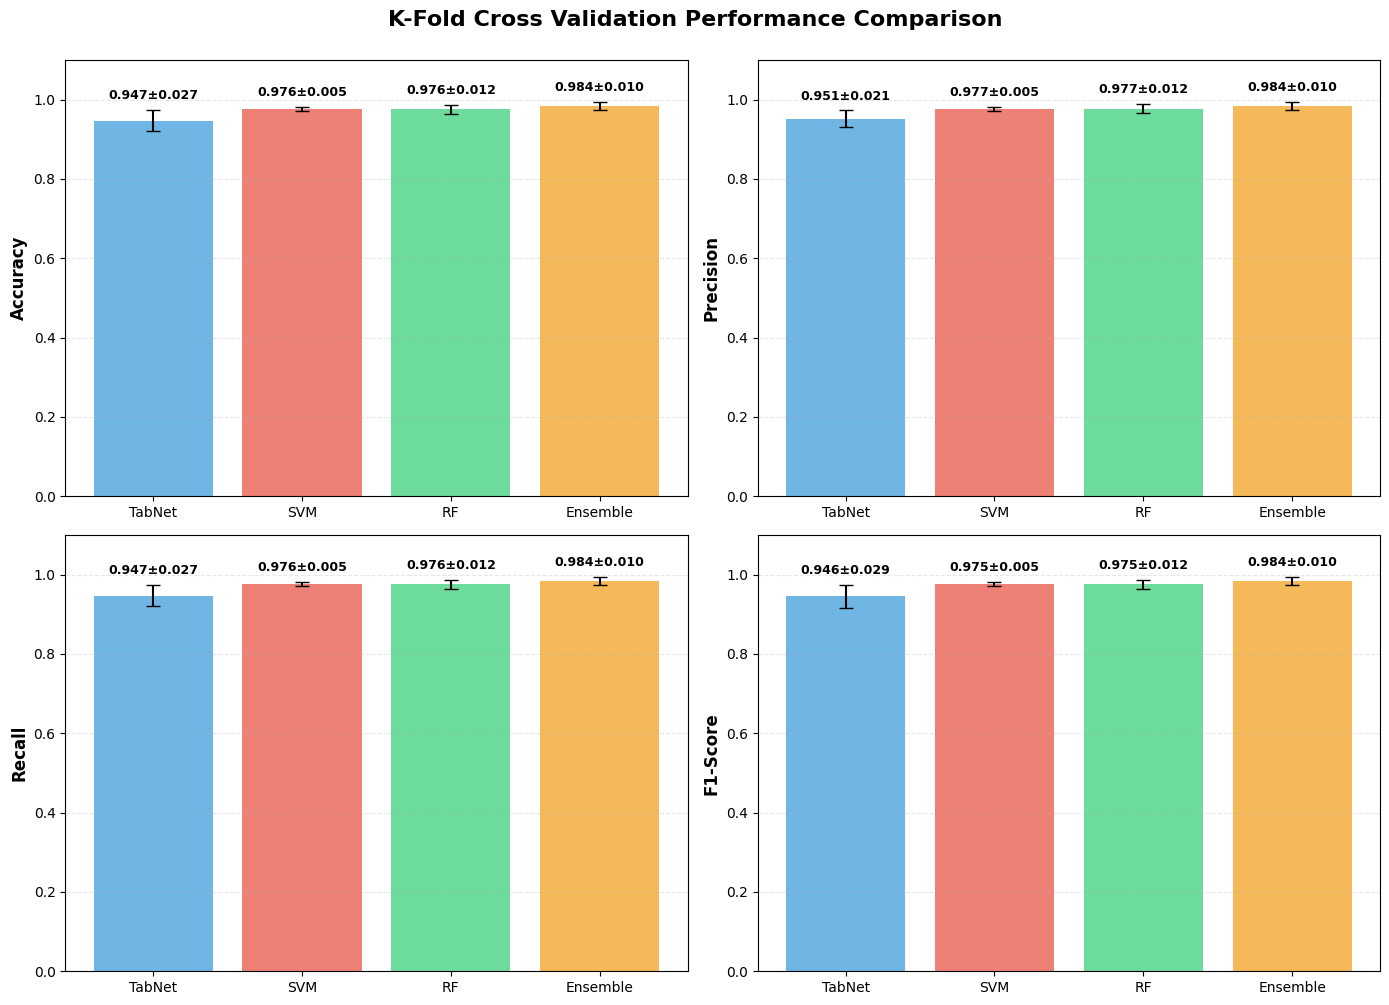


✅ K-fold results saved to 'kfold_results_summary.xlsx'


In [20]:
# Calculate mean and std for each model
results_summary = []

for model_name in ['TabNet', 'SVM', 'RF', 'Ensemble']:
    row = {'Model': model_name}
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        values = fold_results[model_name][metric]
        row[f'{metric}_mean'] = np.mean(values)
        row[f'{metric}_std'] = np.std(values)
    results_summary.append(row)

# Create summary DataFrame
results_df = pd.DataFrame(results_summary)

print("\n" + "="*70)
print("K-FOLD CROSS VALIDATION RESULTS SUMMARY")
print("="*70)
display(results_df)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    models = list(fold_results.keys())
    means = [np.mean(fold_results[m][metric]) for m in models]
    stds = [np.std(fold_results[m][metric]) for m in models]

    bars = ax.bar(models, means, yerr=stds, capsize=5, alpha=0.7, 
                   color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
    
    ax.set_ylabel(label, fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.tick_params(axis='both', labelsize=10)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
                f'{mean:.3f}±{std:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('K-Fold Cross Validation Performance Comparison', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Save results
results_df.to_excel('kfold_results_summary.xlsx', index=False)
print("\n✅ K-fold results saved to 'kfold_results_summary.xlsx'")
                

In [21]:
print("="*60)
print("TRAINING FINAL MODELS ON FULL TRAINING SET")
print("="*60)

# Convert to float32 for TabNet
X_train_tab = X_train.astype(np.float32)
X_test_tab = X_test.astype(np.float32)

# Train TabNet
print("\nTraining TabNet...")
tabnet_final = TabNetClassifier(verbose=0, seed=42, n_d=16, n_a=16, n_steps=3)
tabnet_final.fit(X_train_tab, y_train, 
                 eval_set=[(X_test_tab, y_test)],
                 max_epochs=100, patience=20, batch_size=256)

# Train SVM
print("Training SVM...")
svm_final = SVC(probability=True, kernel='rbf', C=10, gamma='scale', random_state=42)
svm_final.fit(X_train, y_train)

# Train Random Forest
print("Training Random Forest...")
rf_final = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, random_state=42)
rf_final.fit(X_train, y_train)

print("\n✅ Final models trained successfully")

TRAINING FINAL MODELS ON FULL TRAINING SET

Training TabNet...
Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_val_0_accuracy = 0.99048
Training SVM...
Training Random Forest...

✅ Final models trained successfully


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
tabnet_pred_test = tabnet_final.predict(X_test_tab)
tabnet_probs_test = tabnet_final.predict_proba(X_test_tab)

svm_pred_test = svm_final.predict(X_test)
svm_probs_test = svm_final.predict_proba(X_test)

rf_pred_test = rf_final.predict(X_test)
rf_probs_test = rf_final.predict_proba(X_test)

# Ensemble prediction
avg_probs_test = (tabnet_probs_test + svm_probs_test + rf_probs_test) / 3
ensemble_pred_test = np.argmax(avg_probs_test, axis=1)

# Calculate test metrics
test_results = []
for model_name, preds in [('TabNet', tabnet_pred_test), ('SVM', svm_pred_test), 
                          ('RF', rf_pred_test), ('Ensemble', ensemble_pred_test)]:
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted', zero_division=0)
    rec = recall_score(y_test, preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, preds, average='weighted', zero_division=0)
    
    test_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"\n{model_name} Test Performance:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

# Create test results DataFrame
test_results_df = pd.DataFrame(test_results)

print("\n" + "="*60)
print("TEST SET PERFORMANCE SUMMARY")
print("="*60)
display(test_results_df)

# Save test results
test_results_df.to_excel('test_results_summary.xlsx', index=False)
print("\n✅ Test results saved to 'test_results_summary.xlsx'")


TabNet Test Performance:
  Accuracy:  0.9905
  Precision: 0.9909
  Recall:    0.9905
  F1-Score:  0.9905

SVM Test Performance:
  Accuracy:  0.9857
  Precision: 0.9858
  Recall:    0.9857
  F1-Score:  0.9857

RF Test Performance:
  Accuracy:  0.9810
  Precision: 0.9814
  Recall:    0.9810
  F1-Score:  0.9809

Ensemble Test Performance:
  Accuracy:  0.9905
  Precision: 0.9909
  Recall:    0.9905
  F1-Score:  0.9905

TEST SET PERFORMANCE SUMMARY


,Model,Accuracy,Precision,Recall,F1-Score
0,TabNet,0.990476,0.990909,0.990476,0.990471
1,SVM,0.985714,0.985820,0.985714,0.985712
2,RF,0.980952,0.981364,0.980952,0.980942
3,Ensemble,0.990476,0.990909,0.990476,0.990471



✅ Test results saved to 'test_results_summary.xlsx'


In [23]:
# Detailed classification report for the best model (Ensemble)
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT - ENSEMBLE MODEL")
print("="*60)

report = classification_report(y_test, ensemble_pred_test, 
                               target_names=label_encoder.classes_,
                               digits=4)
print(report)

# Save classification report
with open('classification_report.txt', 'w') as f:
    f.write("ENSEMBLE MODEL - CLASSIFICATION REPORT\n")
    f.write("="*60 + "\n\n")
    f.write(report)

print("\n✅ Classification report saved to 'classification_report.txt'")


DETAILED CLASSIFICATION REPORT - ENSEMBLE MODEL
                          precision    recall  f1-score   support

Heat Dissipation Failure     1.0000    1.0000    1.0000        42
              No Failure     1.0000    1.0000    1.0000        42
              Overstrain     1.0000    1.0000    1.0000        42
           Power Failure     1.0000    0.9524    0.9756        42
       Tool Wear Failure     0.9545    1.0000    0.9767        42

                accuracy                         0.9905       210
               macro avg     0.9909    0.9905    0.9905       210
            weighted avg     0.9909    0.9905    0.9905       210


✅ Classification report saved to 'classification_report.txt'


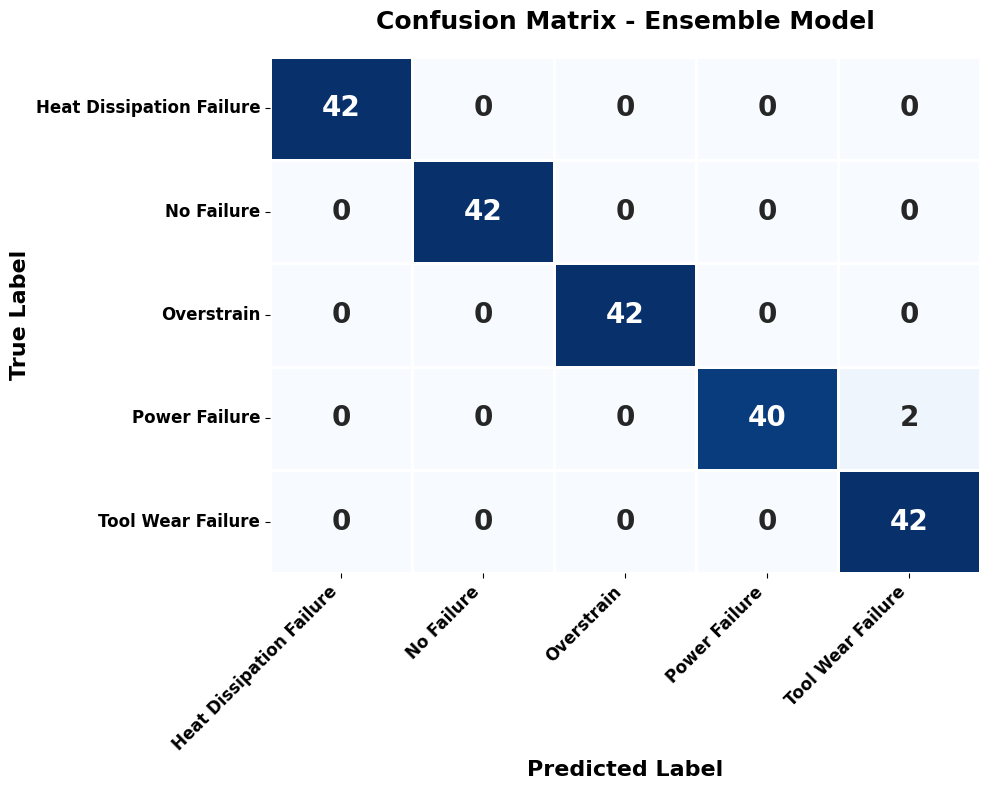

✅ Confusion matrix saved as 'confusion_matrix.png'


In [24]:
# Confusion matrix for ensemble model
cm = confusion_matrix(y_test, ensemble_pred_test)
class_labels = label_encoder.classes_

# Plot styled confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar=False, annot_kws={"size": 20, "fontweight": "bold"},
            linewidths=2, linecolor='white')

plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')
plt.title('Confusion Matrix - Ensemble Model', fontsize=18, fontweight='bold', pad=20)
plt.xticks(fontsize=12, fontweight='bold', rotation=45, ha='right')
plt.yticks(fontsize=12, fontweight='bold', rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved as 'confusion_matrix.png'")

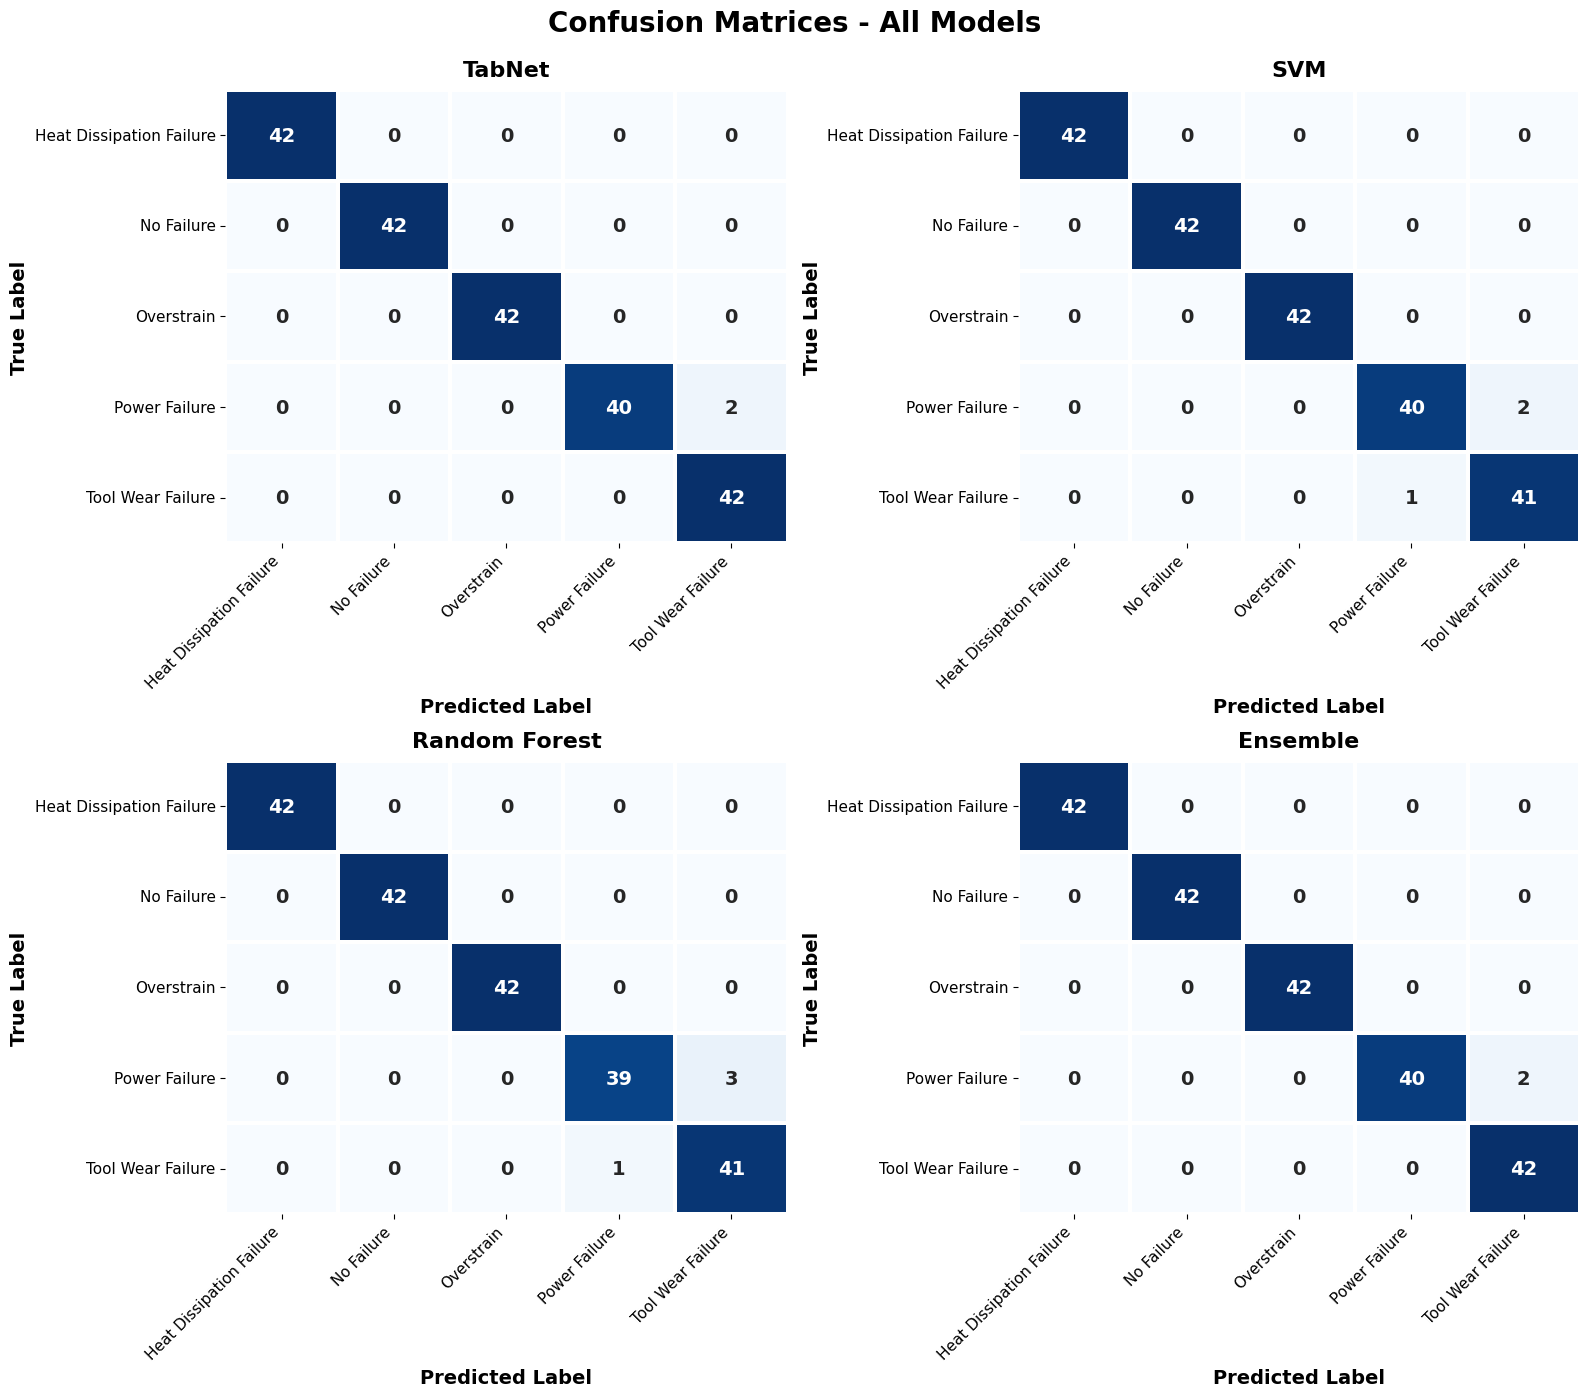

✅ All confusion matrices saved as 'confusion_matrices_all_models.png'


In [25]:
# Create confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
models_preds = [
    ('TabNet', tabnet_pred_test),
    ('SVM', svm_pred_test),
    ('Random Forest', rf_pred_test),
    ('Ensemble', ensemble_pred_test)
]

for idx, (model_name, preds) in enumerate(models_preds):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(y_test, preds)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels,
                cbar=False, annot_kws={"size": 14, "fontweight": "bold"},
                linewidths=1.5, linecolor='white', ax=ax)
    
    ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
    ax.set_title(f'{model_name}', fontsize=16, fontweight='bold', pad=10)
    ax.tick_params(axis='both', labelsize=11)
    
    # Rotate x labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Confusion Matrices - All Models', fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ All confusion matrices saved as 'confusion_matrices_all_models.png'")

Computing UMAP embedding (supervised)...


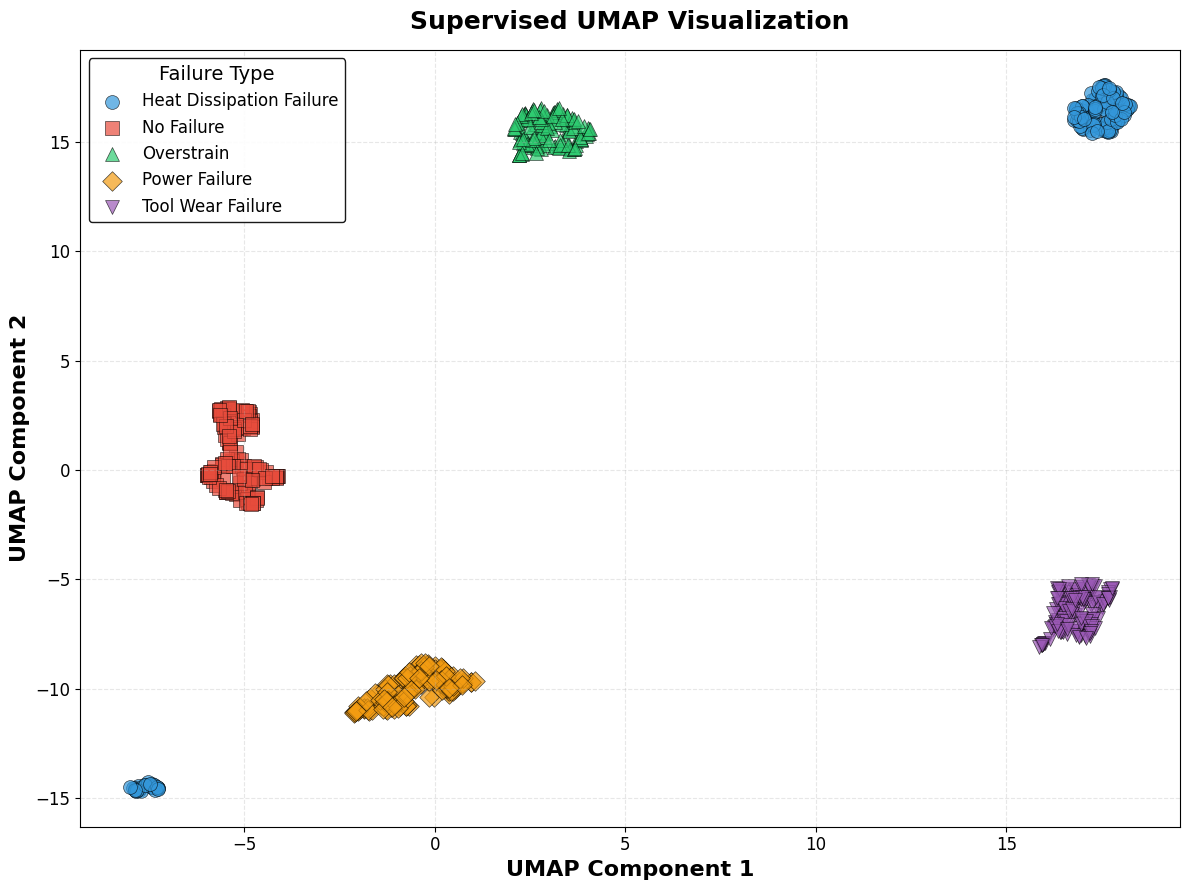

✅ Supervised UMAP visualization saved as 'umap_supervised.png'


In [26]:
import umap

# Supervised UMAP
print("Computing UMAP embedding (supervised)...")
reducer_supervised = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean',
                                random_state=42, n_components=2)
X_umap_supervised = reducer_supervised.fit_transform(X_scaled, y=y_encoded)

# Define visualization parameters
class_names = label_encoder.classes_
markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X'][:len(class_names)]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e'][:len(class_names)]

# Plot supervised UMAP
plt.figure(figsize=(12, 9))
for class_idx, (class_name, marker, color) in enumerate(zip(class_names, markers, colors)):
    class_mask = (y_encoded == class_idx)
    plt.scatter(X_umap_supervised[class_mask, 0], 
                X_umap_supervised[class_mask, 1],
                marker=marker, color=color, label=class_name, 
                s=100, alpha=0.7, edgecolors='black', linewidths=0.5)

plt.xlabel("UMAP Component 1", fontsize=16, fontweight='bold')
plt.ylabel("UMAP Component 2", fontsize=16, fontweight='bold')
plt.title("Supervised UMAP Visualization", fontsize=18, fontweight='bold', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Failure Type", title_fontsize=14, fontsize=12, 
           loc='best', framealpha=0.9, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('umap_supervised.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Supervised UMAP visualization saved as 'umap_supervised.png'")

Computing UMAP embedding (unsupervised)...


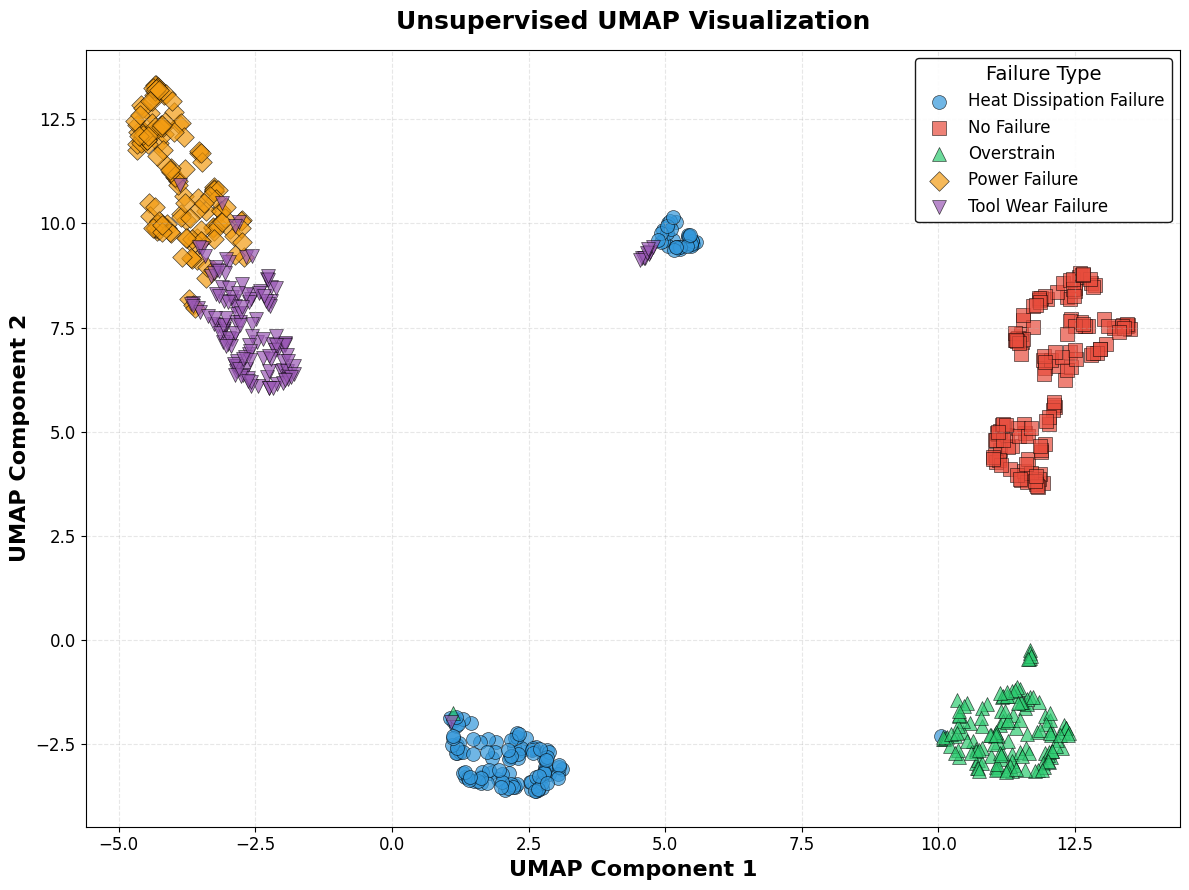

✅ Unsupervised UMAP visualization saved as 'umap_unsupervised.png'


In [27]:
# Unsupervised UMAP
print("Computing UMAP embedding (unsupervised)...")
reducer_unsupervised = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean',
                                  random_state=42, n_components=2)
X_umap_unsupervised = reducer_unsupervised.fit_transform(X_scaled)

# Plot unsupervised UMAP
plt.figure(figsize=(12, 9))
for class_idx, (class_name, marker, color) in enumerate(zip(class_names, markers, colors)):
    class_mask = (y_encoded == class_idx)
    plt.scatter(X_umap_unsupervised[class_mask, 0], 
                X_umap_unsupervised[class_mask, 1],
                marker=marker, color=color, label=class_name, 
                s=100, alpha=0.7, edgecolors='black', linewidths=0.5)

plt.xlabel("UMAP Component 1", fontsize=16, fontweight='bold')
plt.ylabel("UMAP Component 2", fontsize=16, fontweight='bold')
plt.title("Unsupervised UMAP Visualization", fontsize=18, fontweight='bold', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Failure Type", title_fontsize=14, fontsize=12, 
           loc='best', framealpha=0.9, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('umap_unsupervised.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Unsupervised UMAP visualization saved as 'umap_unsupervised.png'")

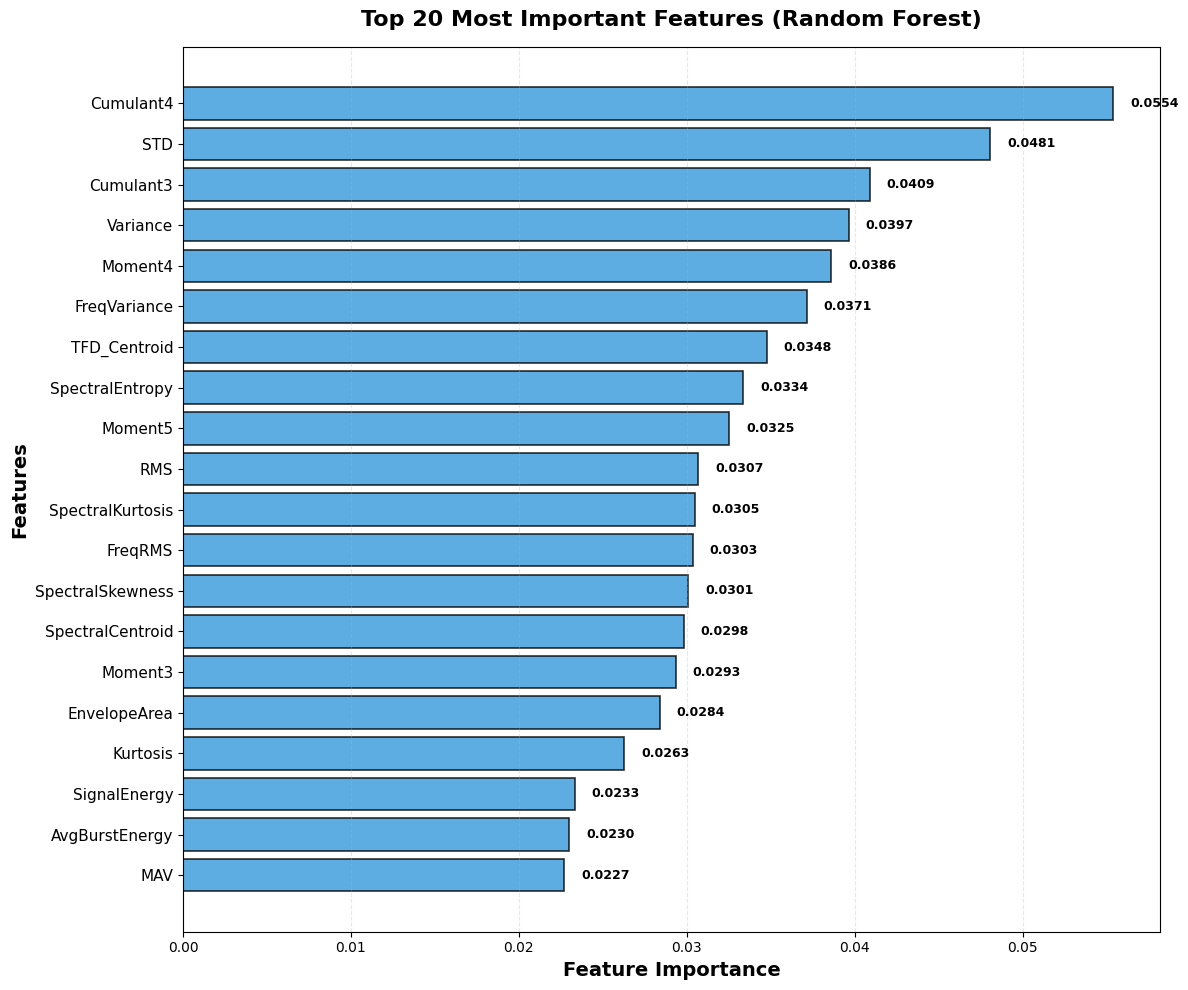

✅ Feature importance saved to 'feature_importance.xlsx'


In [28]:
# Get feature importance from Random Forest
feature_importance = rf_final.feature_importances_
feature_names_list = combined_features.drop(columns=['Label']).columns.tolist()

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 10))
top_n = 20
top_features = importance_df.head(top_n)

bars = plt.barh(range(len(top_features)), top_features['Importance'].values, 
                color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.2)

plt.yticks(range(len(top_features)), top_features['Feature'].values, fontsize=11)
plt.xlabel('Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=14, fontweight='bold')
plt.title(f'Top {top_n} Most Important Features (Random Forest)', 
          fontsize=16, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['Importance'] + 0.001, i, f"{row['Importance']:.4f}", 
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save feature importance
importance_df.to_excel('feature_importance.xlsx', index=False)
print("✅ Feature importance saved to 'feature_importance.xlsx'")

Generating learning curves...
  - SVM...


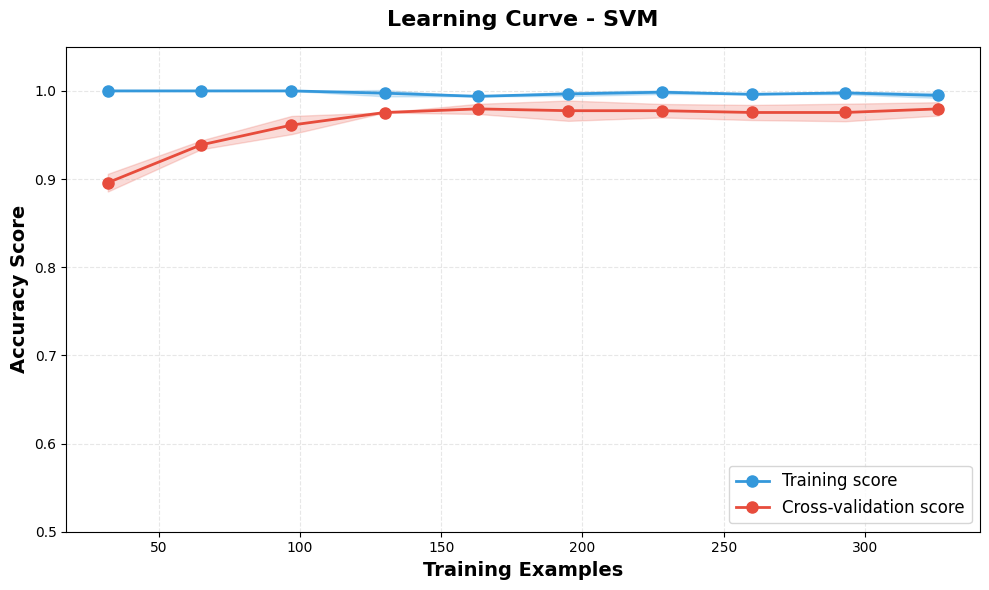

  - Random Forest...


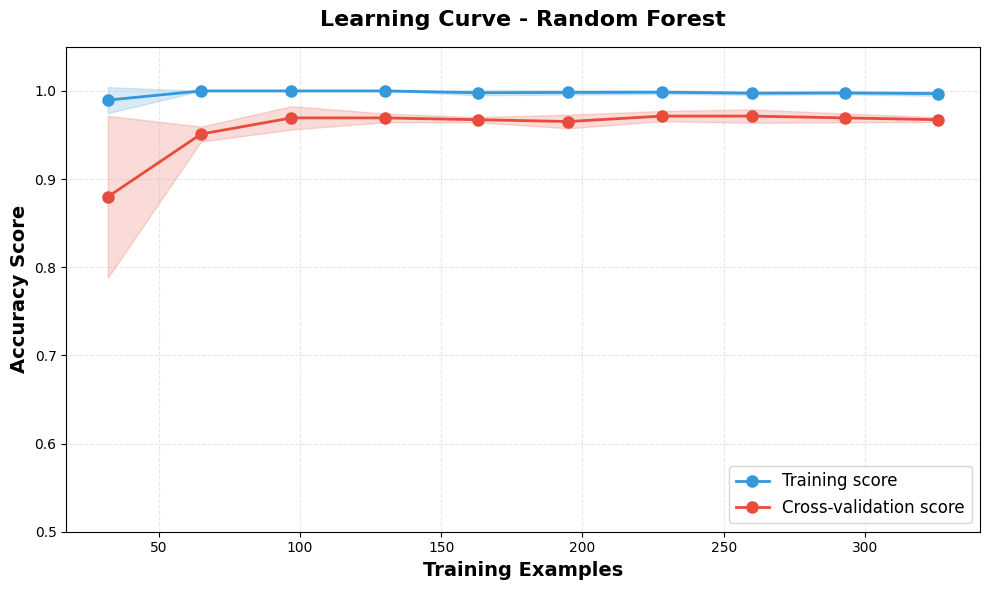

✅ Learning curves saved


In [29]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(0.1, 1.0, 10)):
    """Generate learning curve plot"""
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes, scoring='accuracy', random_state=42
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='#3498db')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color='#e74c3c')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='#3498db', 
             linewidth=2, markersize=8, label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='#e74c3c', 
             linewidth=2, markersize=8, label='Cross-validation score')
    
    plt.xlabel('Training Examples', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy Score', fontsize=14, fontweight='bold')
    plt.title(f'Learning Curve - {title}', fontsize=16, fontweight='bold', pad=15)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.ylim([0.5, 1.05])
    plt.tight_layout()
    
    return plt

# Plot learning curves for each model
print("Generating learning curves...")

# SVM Learning Curve
print("  - SVM...")
plot_svm = plot_learning_curve(svm_final, "SVM", X_train, y_train, cv=3)
plot_svm.savefig('learning_curve_svm.png', dpi=300, bbox_inches='tight')
plot_svm.show()

# Random Forest Learning Curve
print("  - Random Forest...")
plot_rf = plot_learning_curve(rf_final, "Random Forest", X_train, y_train, cv=3)
plot_rf.savefig('learning_curve_rf.png', dpi=300, bbox_inches='tight')
plot_rf.show()

print("✅ Learning curves saved")

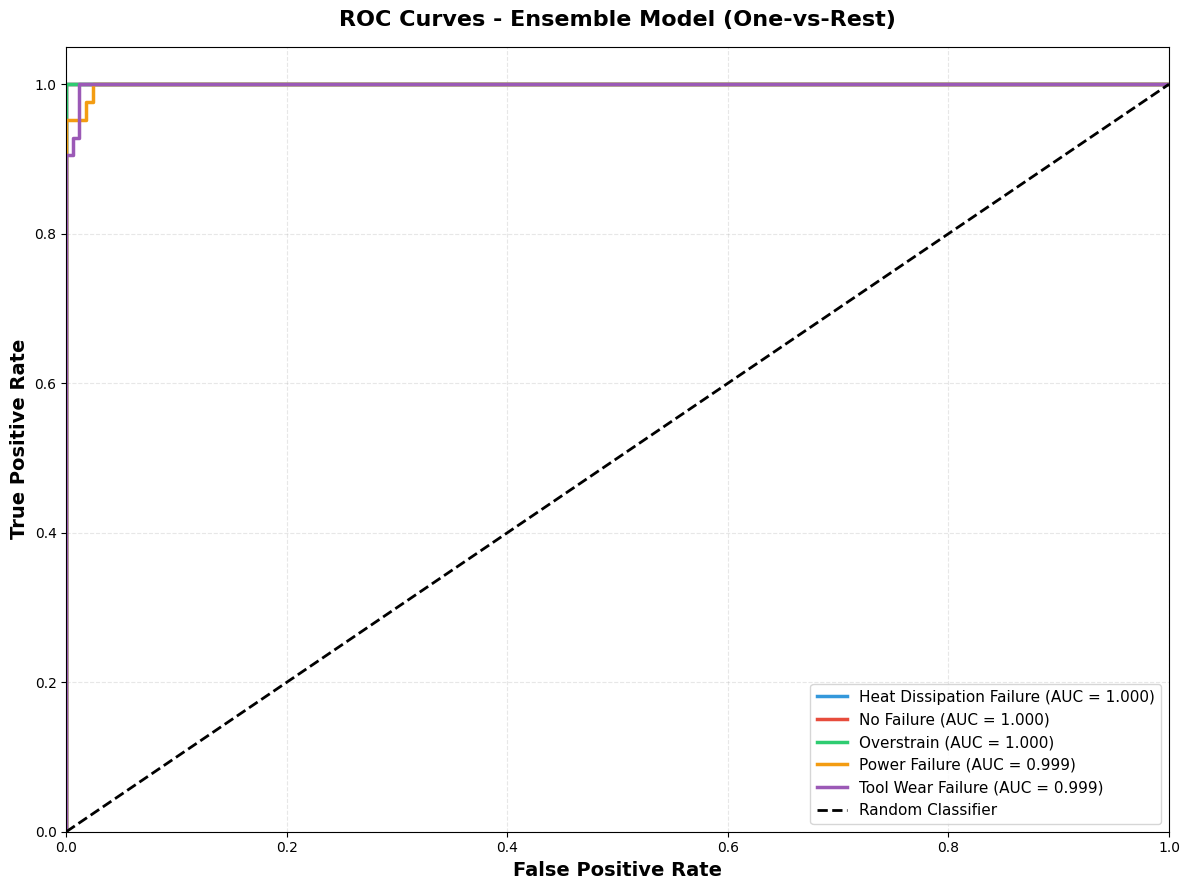

✅ ROC curves saved as 'roc_curves.png'


In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], avg_probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 9))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e']

for i, color in zip(range(n_classes), colors[:n_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves - Ensemble Model (One-vs-Rest)', fontsize=16, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROC curves saved as 'roc_curves.png'")

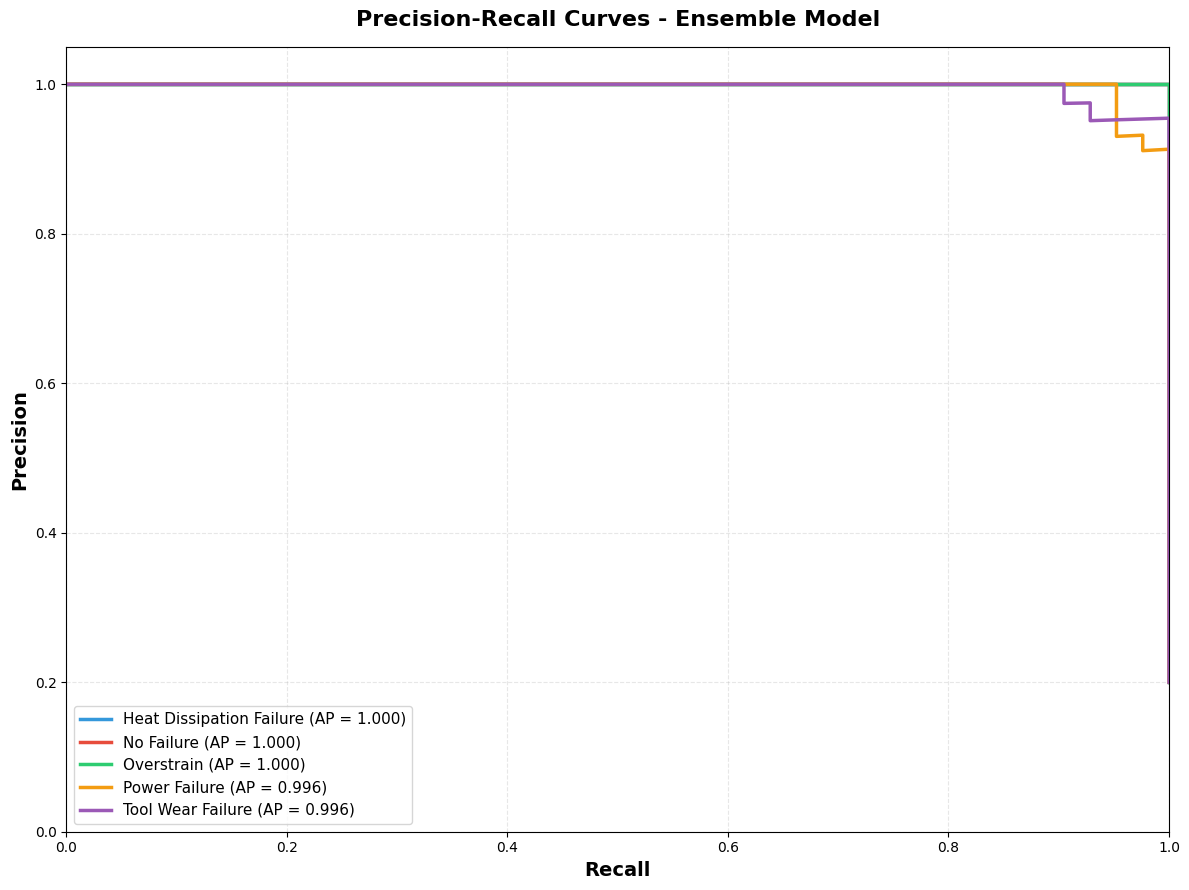

✅ Precision-Recall curves saved as 'precision_recall_curves.png'


In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], avg_probs_test[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], avg_probs_test[:, i])

# Plot Precision-Recall curves
plt.figure(figsize=(12, 9))

for i, color in zip(range(n_classes), colors[:n_classes]):
    plt.plot(recall[i], precision[i], color=color, lw=2.5,
             label=f'{label_encoder.classes_[i]} (AP = {avg_precision[i]:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=14, fontweight='bold')
plt.ylabel('Precision', fontsize=14, fontweight='bold')
plt.title('Precision-Recall Curves - Ensemble Model', fontsize=16, fontweight='bold', pad=15)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Precision-Recall curves saved as 'precision_recall_curves.png'")

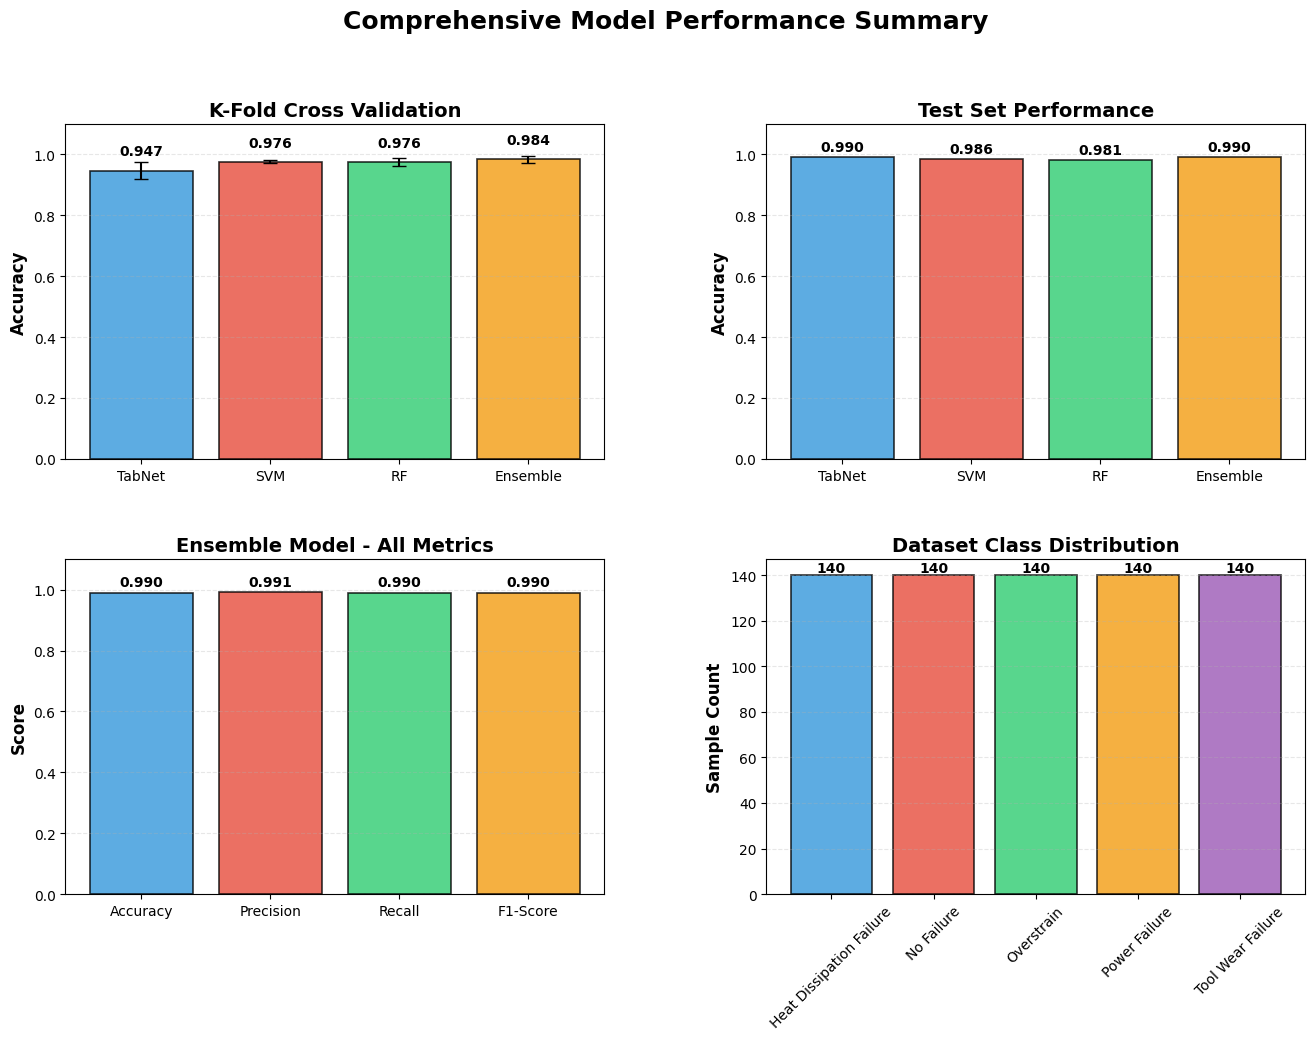

✅ Comprehensive summary saved as 'comprehensive_summary.png'


In [32]:
# Create comprehensive comparison plot
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Subplot 1: K-Fold Results
ax1 = fig.add_subplot(gs[0, 0])
models = ['TabNet', 'SVM', 'RF', 'Ensemble']
kfold_means = [np.mean(fold_results[m]['accuracy']) for m in models]
kfold_stds = [np.std(fold_results[m]['accuracy']) for m in models]
bars1 = ax1.bar(models, kfold_means, yerr=kfold_stds, capsize=5, 
                color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'], 
                alpha=0.8, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('K-Fold Cross Validation', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1.1])
ax1.grid(axis='y', linestyle='--', alpha=0.3)
for bar, mean in zip(bars1, kfold_means):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
             f'{mean:.3f}', ha='center', fontsize=10, fontweight='bold')

# Subplot 2: Test Set Results
ax2 = fig.add_subplot(gs[0, 1])
test_accs = [r['Accuracy'] for r in test_results]
bars2 = ax2.bar(models, test_accs, 
                color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'], 
                alpha=0.8, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Test Set Performance', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1.1])
ax2.grid(axis='y', linestyle='--', alpha=0.3)
for bar, acc in zip(bars2, test_accs):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
             f'{acc:.3f}', ha='center', fontsize=10, fontweight='bold')

# Subplot 3: Ensemble Model Metrics
ax3 = fig.add_subplot(gs[1, 0])
ensemble_metrics = [test_results[3]['Accuracy'], test_results[3]['Precision'], 
                    test_results[3]['Recall'], test_results[3]['F1-Score']]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
bars3 = ax3.bar(metric_names, ensemble_metrics, 
                color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'], 
                alpha=0.8, edgecolor='black', linewidth=1.2)
ax3.set_ylabel('Score', fontsize=12, fontweight='bold')
ax3.set_title('Ensemble Model - All Metrics', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 1.1])
ax3.grid(axis='y', linestyle='--', alpha=0.3)
for bar, val in zip(bars3, ensemble_metrics):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
             f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

# Subplot 4: Class Distribution
ax4 = fig.add_subplot(gs[1, 1])
class_counts = [np.sum(y_encoded == i) for i in range(len(label_encoder.classes_))]
bars4 = ax4.bar(label_encoder.classes_, class_counts, 
                color=colors[:len(label_encoder.classes_)], 
                alpha=0.8, edgecolor='black', linewidth=1.2)
ax4.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
ax4.set_title('Dataset Class Distribution', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', linestyle='--', alpha=0.3)
for bar, count in zip(bars4, class_counts):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(class_counts)*0.01,
             f'{count}', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Comprehensive Model Performance Summary', 
             fontsize=18, fontweight='bold', y=0.995)
plt.savefig('comprehensive_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive summary saved as 'comprehensive_summary.png'")

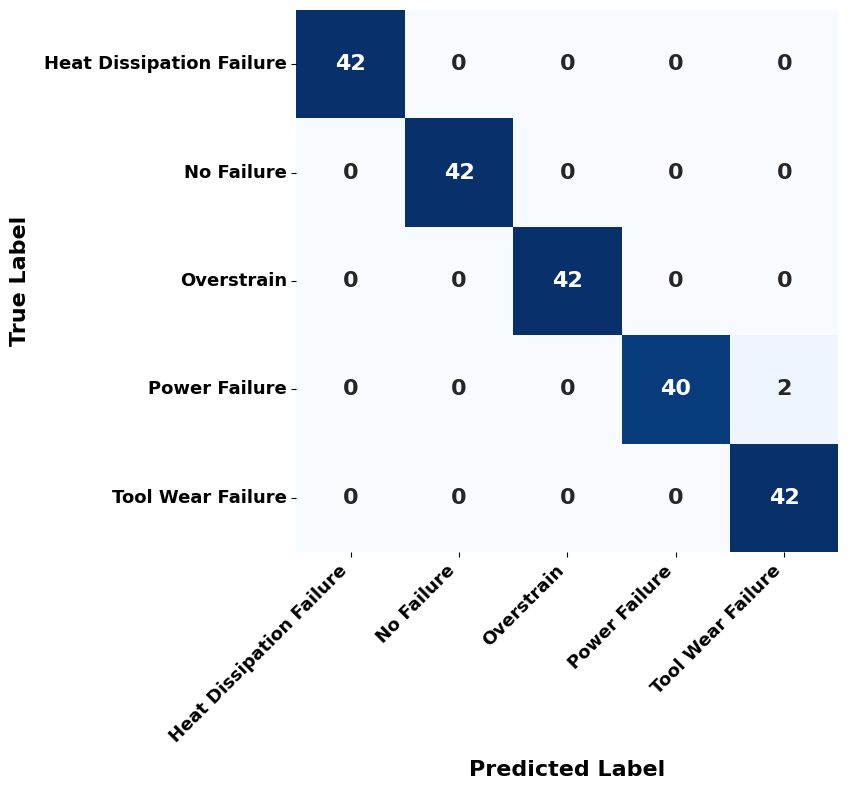


Classification Report:

                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00        42
              No Failure       1.00      1.00      1.00        42
              Overstrain       1.00      1.00      1.00        42
           Power Failure       1.00      0.95      0.98        42
       Tool Wear Failure       0.95      1.00      0.98        42

                accuracy                           0.99       210
               macro avg       0.99      0.99      0.99       210
            weighted avg       0.99      0.99      0.99       210



In [41]:
# ==================================================
# 🎯 Confusion Matrix (counts only - saved separately)
# ==================================================
cm = confusion_matrix(y_test, ensemble_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 16, "fontweight": "bold"},
            square=True)

plt.xlabel("Predicted Label", fontsize=16, fontweight="bold", labelpad=10)
plt.ylabel("True Label", fontsize=16, fontweight="bold", labelpad=10)
#plt.title("Confusion Matrix", fontsize=18, fontweight="bold", pad=15)

# Make tick labels bold and properly aligned
ax = plt.gca()
ax.set_xticklabels(class_names, fontweight="bold", fontsize=13, 
                   rotation=45, ha="right")
ax.set_yticklabels(class_names, fontweight="bold", fontsize=13, 
                   rotation=0, va="center")

plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=600, bbox_inches="tight")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, ensemble_pred_test, target_names=class_names))

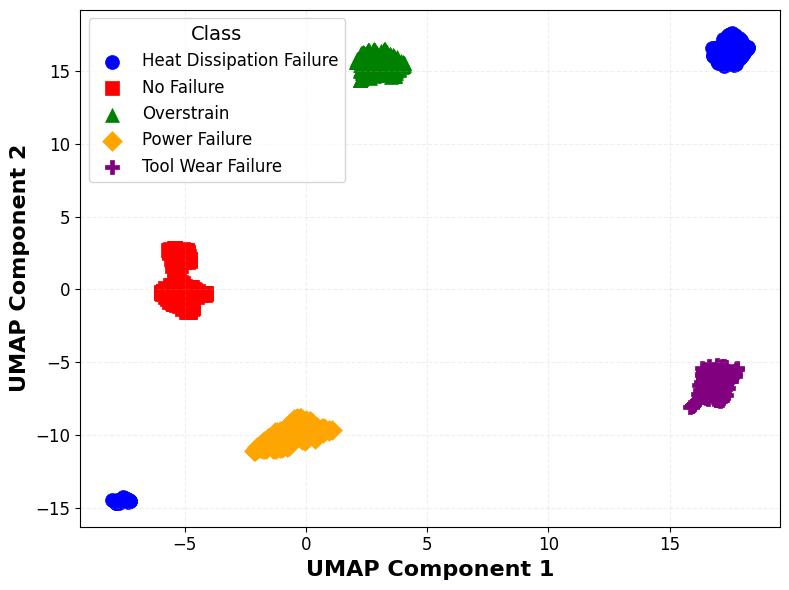

In [44]:
# ==================================================
# 🗺️ Supervised UMAP (nice class-separated view)
#    (fit on the FULL dataset for visualization)
# ==================================================
import matplotlib.pyplot as plt
import numpy as np
import umap
from sklearn.preprocessing import LabelEncoder

# Refit scaler on full dataset for visualization
X_full_s = scaler.fit_transform(X)
y_full = y_enc  # Already encoded from earlier

# Define markers and colors for each class
markers = ['o', 's', '^', 'D', 'P']  # Circle, square, triangle, diamond, plus
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Supervised UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean',
                    random_state=42, target_metric='categorical')
X_umap_supervised = reducer.fit_transform(X_full_s, y=y_full)

# Plot with styled formatting
plt.figure(figsize=(8, 6))
for class_idx, (class_name, marker, color) in enumerate(zip(class_names, markers, colors)):
    class_mask = (y_full == class_idx)
    plt.scatter(X_umap_supervised[class_mask, 0], X_umap_supervised[class_mask, 1],
                marker=marker, color=color, label=class_name, s=100, linewidths=0.5)

plt.xlabel("UMAP Component 1", fontsize=16, fontweight='bold')
plt.ylabel("UMAP Component 2", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Class", title_fontsize=14, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig("umap_supervised.png", dpi=600, bbox_inches="tight")
plt.show()

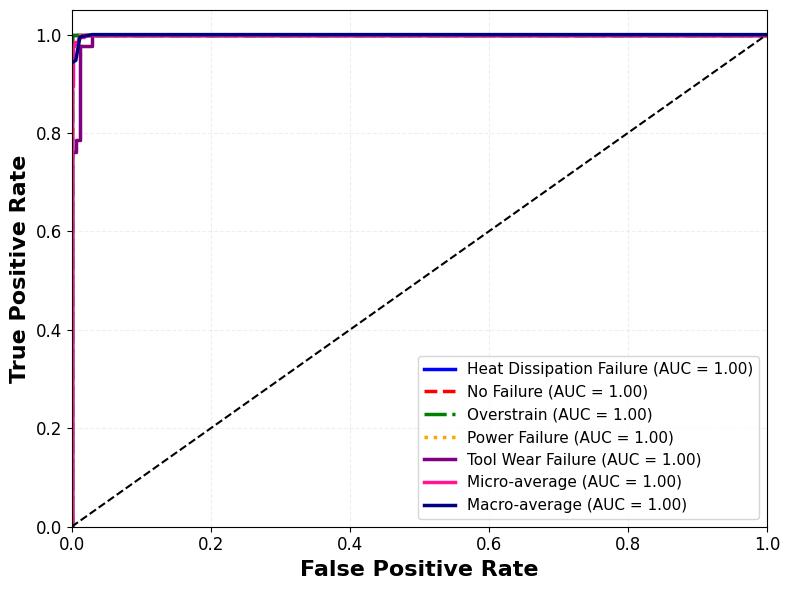

In [45]:
# ==================================================
# 📈 One-vs-Rest ROC (per-class, + micro & macro)
# ==================================================
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize y for ROC
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Per-class ROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
colors = ['blue', 'red', 'green', 'orange', 'purple']
linestyles = ['-', '--', '-.', ':', '-']

plt.figure(figsize=(8, 6))

# Plot per-class ROC
for i, (class_name, color, ls) in enumerate(zip(class_names, colors, linestyles)):
    plt.plot(fpr[i], tpr[i], color=color, linestyle=ls, linewidth=2.5,
             label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

# Plot micro & macro averages
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='-', linewidth=2.5,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='-', linewidth=2.5,
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})')

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig("roc_curves.png", dpi=600, bbox_inches="tight")
plt.show()